In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
sns.set_style('whitegrid')

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [3]:
df_team = pd.read_csv('data/historical_RAPTOR_by_team.csv')
df_player = pd.read_csv('data/historical_RAPTOR_by_player.csv')

In [4]:
print('df_team cols :  ' ,  df_team.columns)
print('df_player cols :  ' ,  df_player.columns)

df_team cols :   Index(['player_name', 'player_id', 'season', 'season_type', 'team', 'poss',
       'mp', 'raptor_offense', 'raptor_defense', 'raptor_total', 'war_total',
       'war_reg_season', 'war_playoffs', 'predator_offense',
       'predator_defense', 'predator_total', 'pace_impact'],
      dtype='object')
df_player cols :   Index(['player_name', 'player_id', 'season', 'poss', 'mp', 'raptor_offense',
       'raptor_defense', 'raptor_total', 'war_total', 'war_reg_season',
       'war_playoffs', 'predator_offense', 'predator_defense',
       'predator_total', 'pace_impact'],
      dtype='object')


In [5]:
# I am going to work with the player df, and concentrate on the raptor stats, not the predator (which are predictions).
# a reasonable target for now would be the war columnns
# first I'll clcean the data a bit

df = df_player[['player_name', 'player_id', 'season', 'poss', 'mp', 'raptor_offense',
       'raptor_defense', 'raptor_total', 'war_total', 'war_reg_season',
       'war_playoffs', 'pace_impact']]


In [6]:
df.isnull().sum()
# just one null value in pace_impact

player_name       0
player_id         0
season            0
poss              0
mp                0
raptor_offense    0
raptor_defense    0
raptor_total      0
war_total         0
war_reg_season    0
war_playoffs      0
pace_impact       1
dtype: int64

In [7]:
df.nunique()
# there are more ids than names

player_name        3442
player_id          3464
season               45
poss               6415
mp                 3598
raptor_offense    18553
raptor_defense    18552
raptor_total      18553
war_total         18550
war_reg_season    18540
war_playoffs       8330
pace_impact       18542
dtype: int64

In [8]:
df.groupby('player_name')['player_id'].nunique().sort_values().tail(20)
df[df['player_name'] == 'Glen Rice']
# it seems that there a few players with the same name
# we'll trust that the player_id is a good distinctive between different players

,player_name,player_id,season,poss,mp,raptor_offense,raptor_defense,raptor_total,war_total,war_reg_season,war_playoffs,pace_impact
13947,Glen Rice,ricegl01,1990,4919,2311,-2.809117,-0.519353,-3.328469,-0.681837,-0.681837,0.000000,-0.032185
13948,Glen Rice,ricegl01,1991,5537,2646,-0.609174,-0.006316,-0.615490,2.884085,2.884085,0.000000,0.086674
13949,Glen Rice,ricegl01,1992,6424,3126,2.073958,-0.561902,1.512056,6.764471,6.921369,-0.156898,-0.106299
13950,Glen Rice,ricegl01,1993,6144,3082,0.943388,-0.074404,0.868983,5.689930,5.689930,0.000000,-0.011900
13951,Glen Rice,ricegl01,1994,6297,3194,2.430118,0.819855,3.249973,9.774483,9.346251,0.428232,-0.071752
13952,Glen Rice,ricegl01,1995,5900,3014,3.639946,-0.002511,3.637435,9.805816,9.805816,0.000000,-0.157176
13953,Glen Rice,ricegl01,1996,6065,3142,3.093041,-0.658377,2.434663,8.287371,8.287371,0.000000,-0.267197
13954,Glen Rice,ricegl01,1997,6528,3499,4.035984,-1.202997,2.832987,9.937278,9.251019,0.686258,-0.516895
13955,Glen Rice,ricegl01,1998,6857,3664,2.261625,-0.929810,1.331814,7.636716,6.686706,0.950010,-0.394452
13956,Glen Rice,ricegl01,1999,2489,1292,2.249545,-1.412263,0.837282,2.376010,1.707741,0.668269,-0.336709


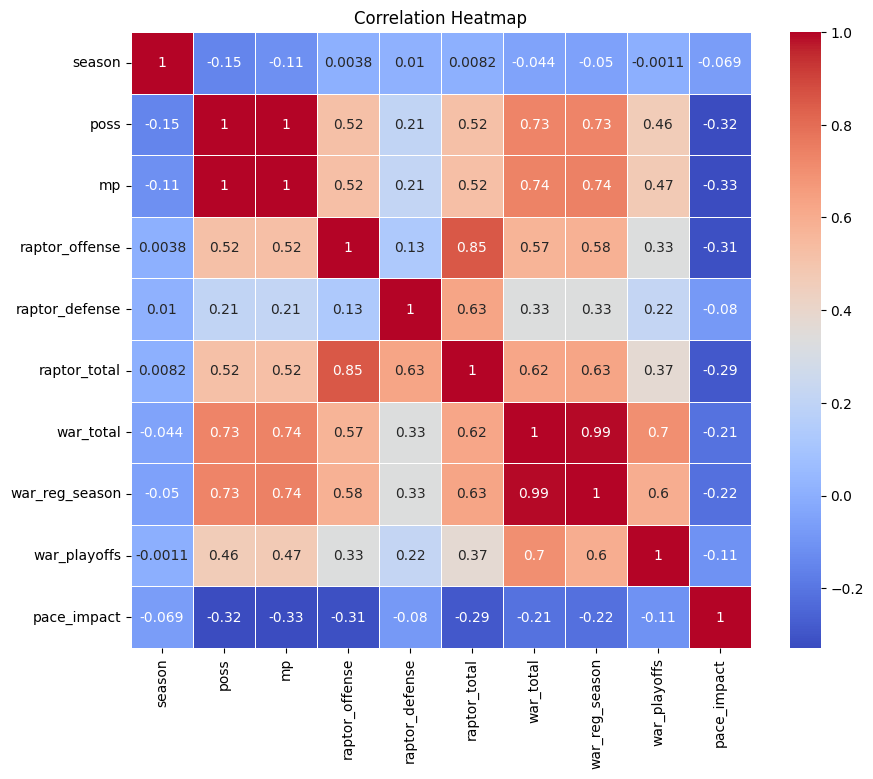

In [45]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Create the heatmap
plt.figure(figsize=(10, 8))  # Set the size of the plot
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

# scatter matrix if needed
# scatter_matrix(df, alpha=0.2, figsize=(10, 8), diagonal='hist')
# plt.show()

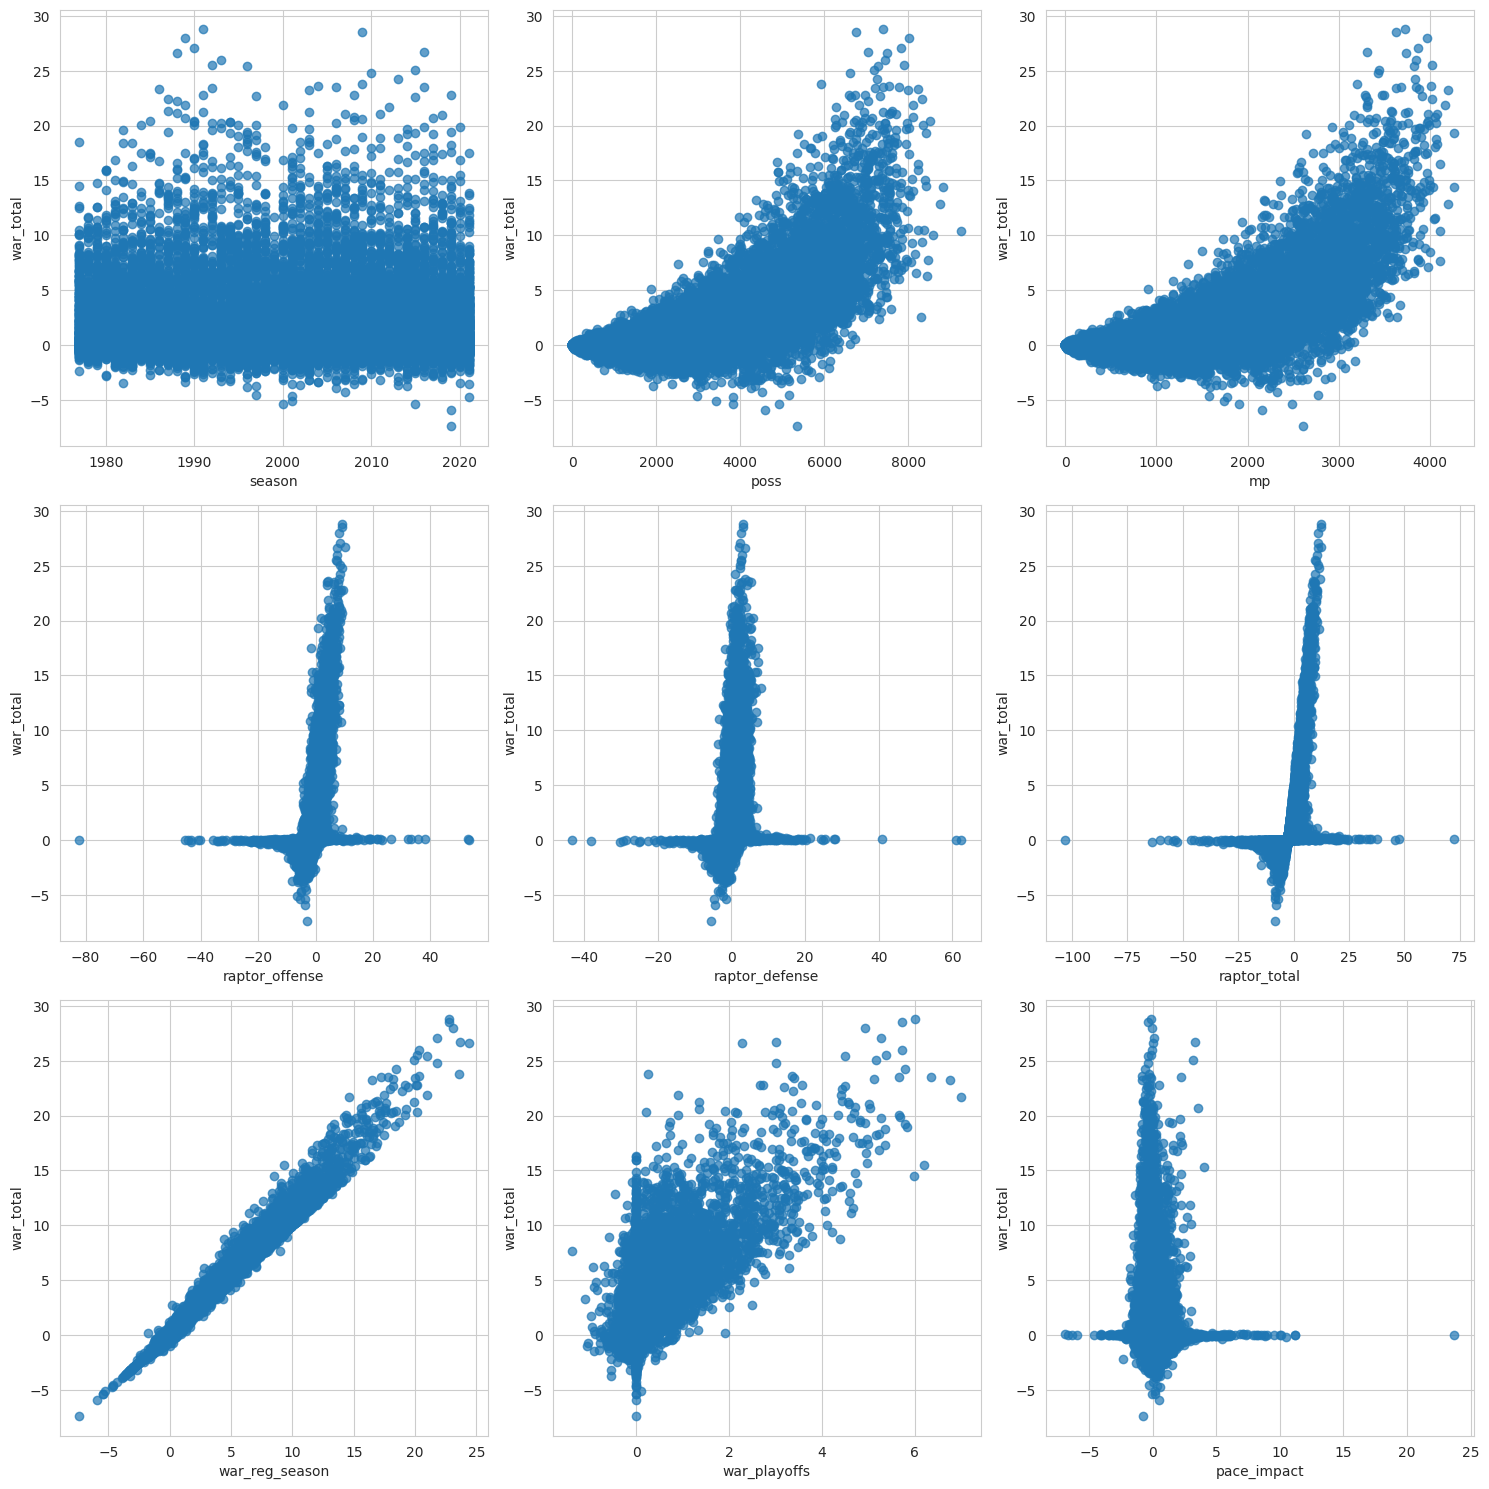

In [65]:
# I am going to target war_total
# scatter war_total against all other features

# Filter only numeric features to avoid errors
# Filter numeric columns and exclude 'war_total'
numeric_features = df.select_dtypes(include='number').drop(columns=['war_total']).columns

# Set up the subplots
n_features = len(numeric_features)  # Exclude 'war_total'
n_cols = 3
n_rows = 3

f, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 15))
axs = axs.flatten()  # Flatten the 2D array of axes

# Plot 'war_total' against other numeric features
for feature, ax in zip(numeric_features, axs):
    if feature != 'war_total':
        ax.scatter(df[feature], df['war_total'], alpha=0.7)
        ax.set_xlabel(feature)
        ax.set_ylabel('war_total')



plt.tight_layout()
plt.show()


In [20]:
# I'll just keep war_total, raptor_total, pace impact. Also mp and poss, but I'll test the new feature poss/mp
df['poss/mp'] = df['poss']/df['mp']
df = df[['player_name',	'player_id','poss',	'mp','poss/mp' ,	'raptor_total',	'war_total',	'pace_impact',]]
df[['poss/mp']] = df[['poss/mp']].replace([np.inf, -np.inf], np.nan)
df.head()

,player_name,player_id,poss,mp,poss/mp,raptor_total,war_total,pace_impact
0,Alaa Abdelnaby,abdelal01,640,303,2.112211,-4.448526,-0.265191,0.199241
1,Alaa Abdelnaby,abdelal01,1998,959,2.083420,-2.751792,-0.006893,0.485436
2,Alaa Abdelnaby,abdelal01,2754,1379,1.997099,-4.443544,-1.227189,0.488266
3,Alaa Abdelnaby,abdelal01,320,159,2.012579,-8.888368,-0.500600,0.511152
4,Alaa Abdelnaby,abdelal01,984,506,1.944664,-5.114556,-0.615802,1.545922


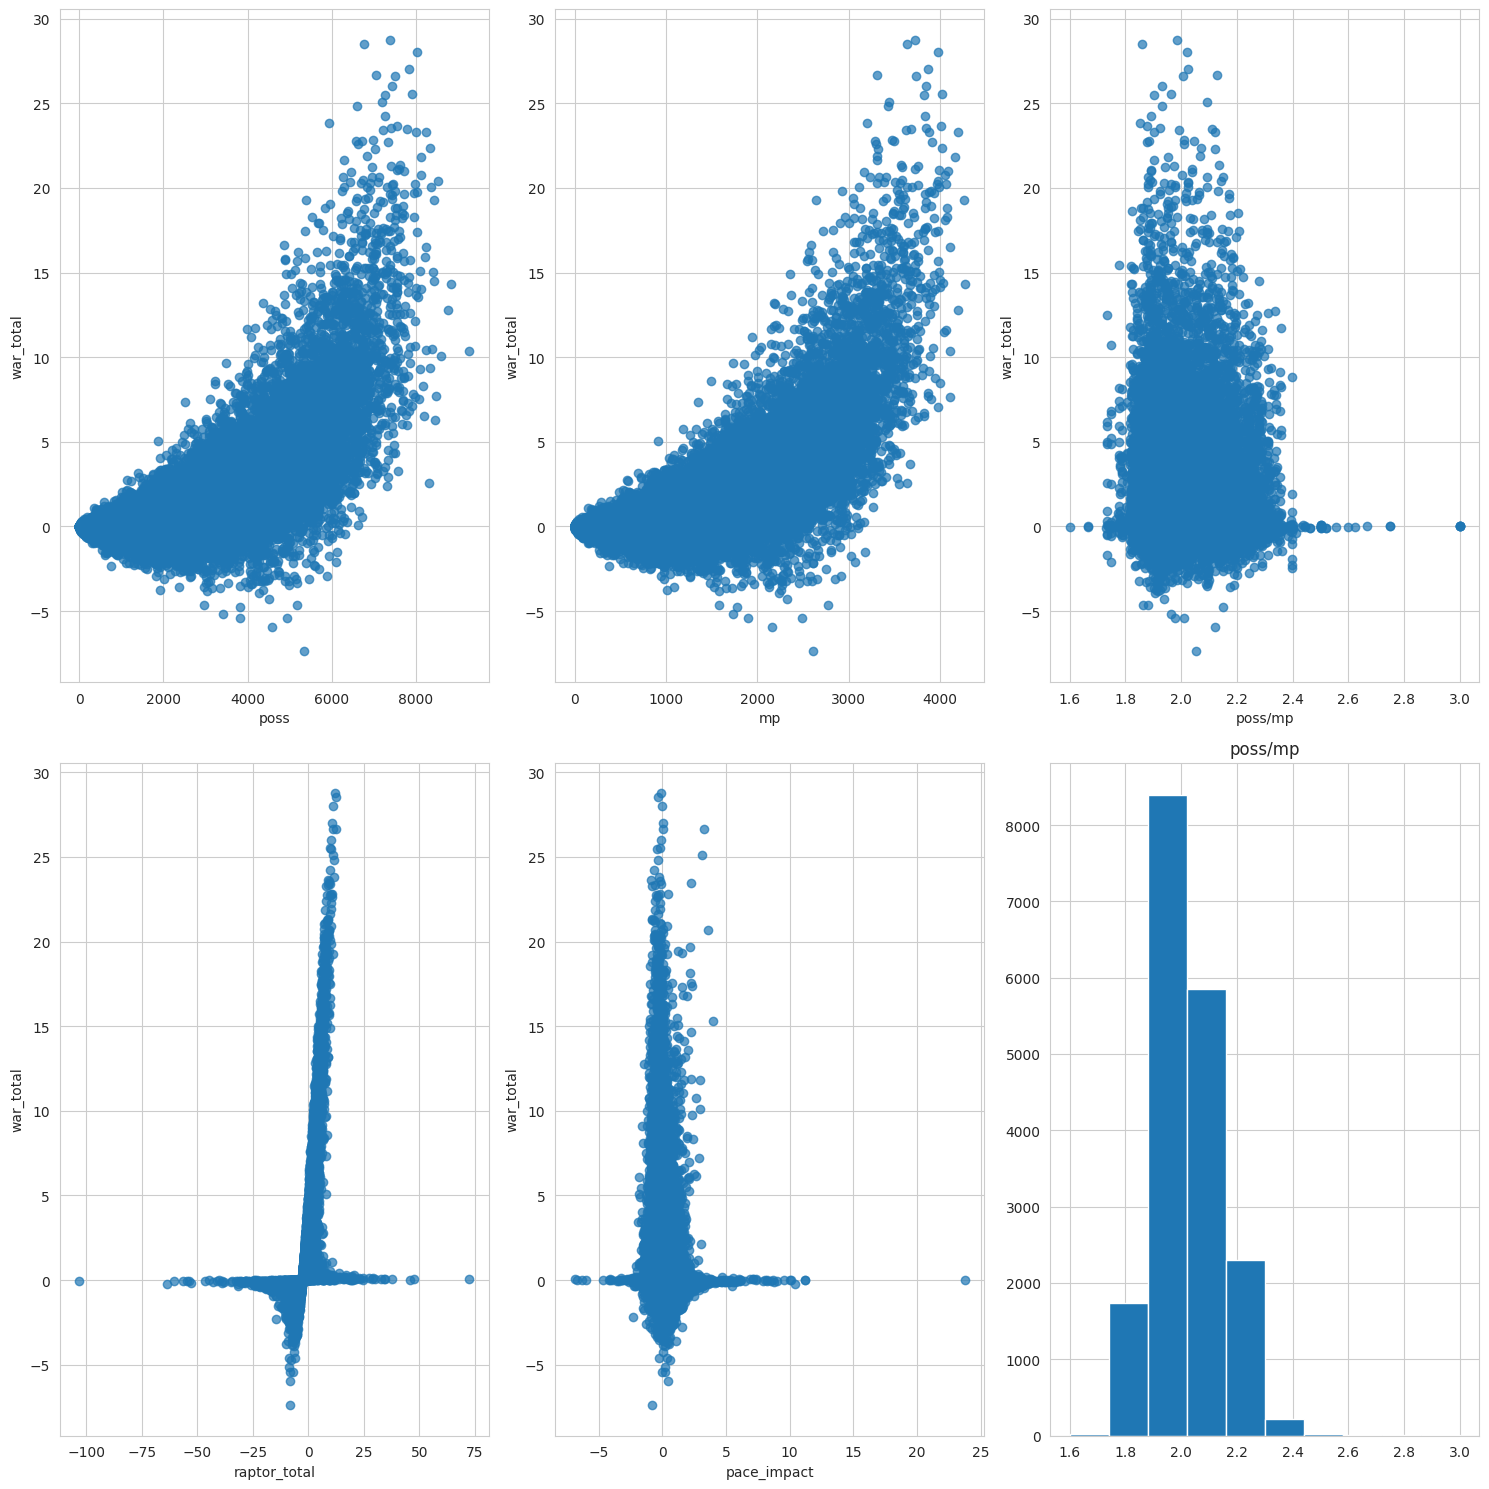

In [21]:
# Filter only numeric features to avoid errors
# Filter numeric columns and exclude 'war_total'
numeric_features = df.select_dtypes(include='number').drop(columns=['war_total']).columns

# Set up the subplots
n_features = len(numeric_features)  # Exclude 'war_total'
n_cols = 3
n_rows = 2

f, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 15))
axs = axs.flatten()  # Flatten the 2D array of axes

# Plot 'war_total' against other numeric features
for feature, ax in zip(numeric_features, axs):
    if feature != 'war_total':
        ax.scatter(df[feature], df['war_total'], alpha=0.7)
        ax.set_xlabel(feature)
        ax.set_ylabel('war_total')
df[['poss/mp']].hist(ax = axs[-1])

plt.tight_layout()
plt.show()

In [22]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[['raptor_total', 'war_total']])

In [ ]:
# calculate inertia and silhouette scores for different k
inertia = []
silhouette_scores = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    # Calculate the silhouette score for each k
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

f,axs = plt.subplots(ncols=2, figsize = (15,5))

axs[0].plot(range(2, 10), silhouette_scores, marker='o')
axs[0].set_xlabel('Number of clusters')
axs[0].set_ylabel('Silhouette Score')
axs[0].set_title('Silhouette Scores for Different Numbers of Clusters')

axs[1].plot(range(1, 10), inertia, marker='o')
axs[1].set_xlabel('Number of clusters')
axs[1].set_ylabel('Inertia')


/home/lpancotto/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


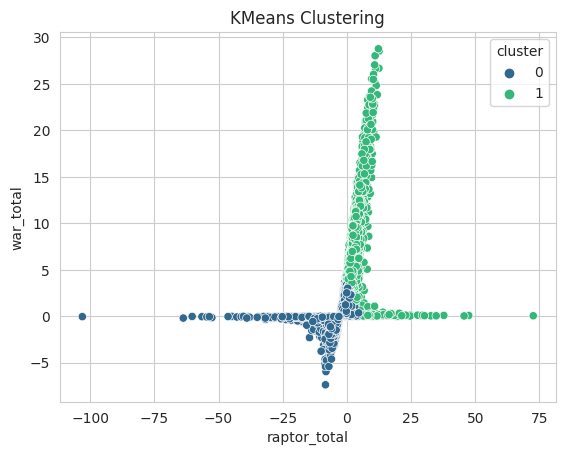

In [37]:
kmeans = KMeans(n_clusters=2)  # Start with 2 clusters
df['cluster'] = kmeans.fit_predict(X_scaled)  # Assign cluster labels

sns.scatterplot(x=df['raptor_total'], y=df['war_total'], hue=df['cluster'], palette='viridis')
plt.title('KMeans Clustering')
plt.show()


It seems that clustering into two groups is reasonable. Seeing how the division is made, it is effectively trying to divide the data into 'bad' cases (negative values of raptor total) and 'good' cases (positive values of raptor total). This is fairly obvious. But since the raptor stat is per 100 posessions, It would be interesting to see what clusters appear when we add the 'poss' dimension: I would expect that the players that are close to 0 in war total axis are the ones with less possesion. 

<AxesSubplot:xlabel='raptor_total', ylabel='war_total'>

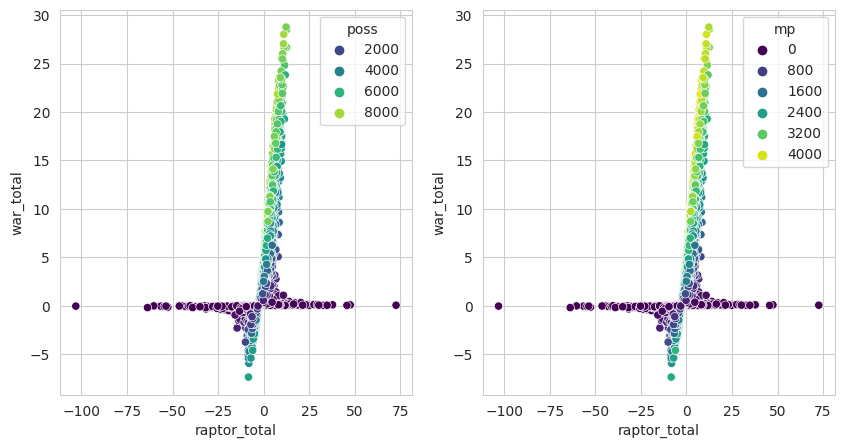

In [46]:
f,axs = plt.subplots(ncols=2 , figsize = (10,5))
sns.scatterplot(x=df['raptor_total'], y=df['war_total'], hue=df['poss'], palette='viridis', ax = axs[0])
sns.scatterplot(x=df['raptor_total'], y=df['war_total'], hue=df['mp'], palette='viridis', ax = axs[1])


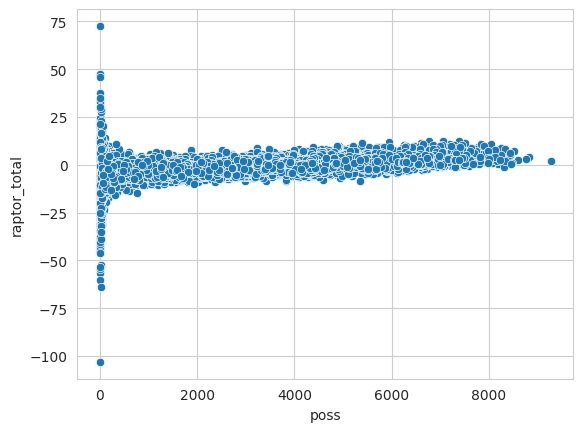

In [53]:
sns.scatterplot(x=df['poss'], y=df['raptor_total'], palette='viridis')
plt.show()

as expected the cases with less possesion or minutes played are not so significant to war total, and their raptor stat doesnt really but them in a good or bad position there.

/home/lpancotto/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/lpancotto/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/lpancotto/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/lpancotto/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1

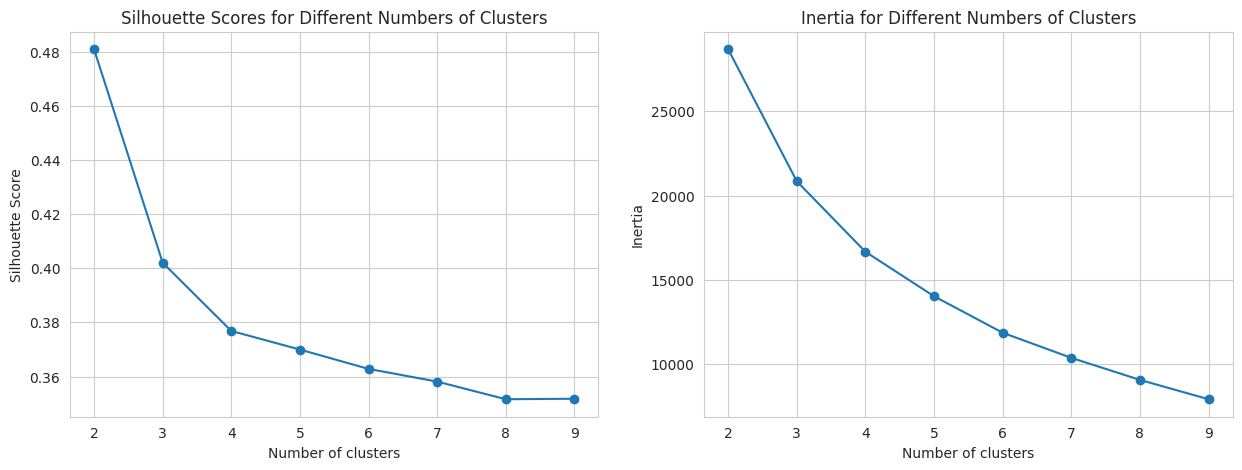

In [47]:

# 1. Scale the three features: 'raptor_total', 'war_total', 'poss'
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[['raptor_total', 'war_total', 'poss']])

# 2. Initialize lists to store inertia and silhouette scores
inertia = []
silhouette_scores = []

# 3. Loop over different numbers of clusters (k)
for k in range(2, 10):  # start from 2 clusters since silhouette score is undefined for 1 cluster
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_scaled)

    # Calculate inertia (sum of squared distances to cluster centers)
    inertia.append(kmeans.inertia_)

    # Calculate silhouette score for each k
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# 4. Plot both inertia and silhouette scores side by side
f, axs = plt.subplots(ncols=2, figsize=(15,5))

# Plot silhouette scores
axs[0].plot(range(2, 10), silhouette_scores, marker='o')
axs[0].set_xlabel('Number of clusters')
axs[0].set_ylabel('Silhouette Score')
axs[0].set_title('Silhouette Scores for Different Numbers of Clusters')

# Plot inertia
axs[1].plot(range(2, 10), inertia, marker='o')
axs[1].set_xlabel('Number of clusters')
axs[1].set_ylabel('Inertia')
axs[1].set_title('Inertia for Different Numbers of Clusters')

plt.show()


/home/lpancotto/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


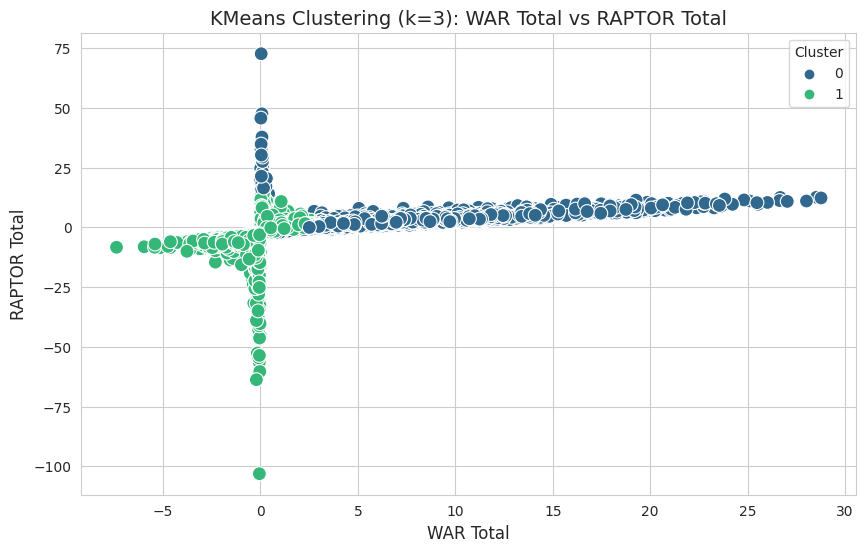

In [49]:
# 1. Scale the three features: 'raptor_total', 'war_total', 'poss'
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[['raptor_total', 'war_total', 'poss']])

# 2. Perform KMeans clustering with k = 3
kmeans = KMeans(n_clusters=2, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)  # Save cluster labels in the dataframe

# 3. Create scatter plot of war_total vs raptor_total with hue showing clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='war_total', y='raptor_total', hue='cluster', palette='viridis', data=df, s=100)

# 4. Add plot labels and title
plt.title('KMeans Clustering (k=3): WAR Total vs RAPTOR Total', fontsize=14)
plt.xlabel('WAR Total', fontsize=12)
plt.ylabel('RAPTOR Total', fontsize=12)
plt.legend(title='Cluster')
plt.show()